In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.io as sio
import numpy as np

import skimage.io
import h5py
import sys

sys.path.append("../../Data_Preprocessing/")
sys.path.append("../Metric/")
from Preprocess_Utilities import *
from Metric import *
from Data_Extractor import *

In [2]:
# restore trained model & training info into session
model_name = 'motor_trunk_pri_sec_tert'
model_path = './Result/motor_trunk_pri_sec_tert/'

sess = tf.InteractiveSession()
saver = tf.train.import_meta_graph( model_path + model_name + '.meta')
saver.restore(sess, tf.train.latest_checkpoint(model_path))

INFO:tensorflow:Restoring parameters from ./Result/motor_trunk_pri_sec_tert/Naive NN - central pixel/motor_trunk_pri_sec_tert


In [3]:
training_info = h5py.File(model_path + 'training_info.h5')
index = training_info['Index']
norm  = training_info['Norm']

train_index = np.array(index['train_index'])
test_index  = np.array(index['test_index'])
mu    = np.array(norm['mu'])
sigma = np.array(norm['sigma'])
training_info.close()

In [4]:
print(train_index.shape, test_index.shape, mu.shape, sigma.shape)

(12865797,) (4288599,) (5488,) (5488,)


In [5]:
# read in & re-construct training/test set
path_raw_image = "../../Data/090085/090085_20170531.h5"
path_road_mask = "../../Data/090085/Road_Data/" + model_name + "/" + model_name + ".tif"
path_topleft_coordinate = "../../Data/090085/Road_Data/" + model_name + "/topleft_coordinate.h5"

raw_image = np.array(h5py.File(path_raw_image)['scene'])
road_mask = skimage.io.imread(path_road_mask)

data = h5py.File(path_topleft_coordinate, 'r')
topleft_coordinate = np.array(data['topleft_coordinate'])
data.close()

print(raw_image.shape, road_mask.shape)
print(raw_image.min())

(7, 7961, 8091) (7961, 8091)
-9999


In [6]:
# list all names for nodes in TFgraph
graph = tf.get_default_graph()
for op in graph.get_operations():
    print(op.name)

x
y
truncated_normal/shape
truncated_normal/mean
truncated_normal/stddev
truncated_normal/TruncatedNormal
truncated_normal/mul
truncated_normal
Variable
Variable/Assign
Variable/read
truncated_normal_1/shape
truncated_normal_1/mean
truncated_normal_1/stddev
truncated_normal_1/TruncatedNormal
truncated_normal_1/mul
truncated_normal_1
Variable_1
Variable_1/Assign
Variable_1/read
MatMul
add
Relu
truncated_normal_2/shape
truncated_normal_2/mean
truncated_normal_2/stddev
truncated_normal_2/TruncatedNormal
truncated_normal_2/mul
truncated_normal_2
Variable_2
Variable_2/Assign
Variable_2/read
truncated_normal_3/shape
truncated_normal_3/mean
truncated_normal_3/stddev
truncated_normal_3/TruncatedNormal
truncated_normal_3/mul
truncated_normal_3
Variable_3
Variable_3/Assign
Variable_3/read
MatMul_1
add_1
Relu_1
truncated_normal_4/shape
truncated_normal_4/mean
truncated_normal_4/stddev
truncated_normal_4/TruncatedNormal
truncated_normal_4/mul
truncated_normal_4
Variable_4
Variable_4/Assign
Variabl

In [7]:
# get tensor => tensor name = operation name : output index
x = graph.get_tensor_by_name("x:0")
y = graph.get_tensor_by_name("y:0")
prediction = graph.get_tensor_by_name("prediction:0")
pred_prob  = graph.get_tensor_by_name("y_CNN:0")

In [ ]:
# predict & plot the road mask
pred_road = np.zeros(road_mask.shape)
for coord, img in iterate_raw_image_with_coord:
    pred_road[coord[0], coord[1]] = pred_prob.eval(
        feed_dict={x:((img-mu)/sigma).reshape((-1,band,height,width)).transpose((0,2,3,1)).astype(np.float32),
                   keep_prob = 1,
                   is_training = False})

In [9]:
# predict training & test set

# training set
train_metric = Metric(record_index=True)

batch_size = 64
batch_num = int(train_index.size/batch_size)+1
for i in range(batch_num):
    start = i%batch_num * batch_size
    end = start + batch_size

    if end > train_index.size:
        end = train_index.size
    
    index = train_index[start:end]
    batch_x, batch_y = get_patches(raw_image, road_mask, topleft_coordinate[index], step=28)
    batch = [((batch_x-mu)/sigma), np.matrix(batch_y).astype(int).T]
    
    # record metric
    pred = prediction.eval(feed_dict={x:batch[0]})
    train_metric.accumulate(pred, batch[1])
    train_pred_label[start:end] = pred.T
    
print("Training Result:")
train_metric.print_info()
print()

# test set
test_metric = Metric(record_index=True)

batch_size = 64
batch_num = int(test_index.size/batch_size)+1
for i in range(batch_num):
    start = i%batch_num * batch_size
    end = start + batch_size

    if end > test_index.size:
        end = test_index.size
    
    index = test_index[start:end]
    batch_x, batch_y = get_patches(raw_image, road_mask, topleft_coordinate[index], step=28)
    batch = [((batch_x-mu)/sigma), np.matrix(batch_y).astype(int).T]

    # record metric   
    pred = prediction.eval(feed_dict={x:batch[0]})
    test_metric.accumulate(pred, batch[1])
    test_pred_label[start:end] = pred.T

print("Test Result:")
test_metric.print_info()

Test Result:
true_pos  = 97
false_pos = 2218
true_neg  = 4269464
false_neg = 16820
size = 4288599
pos_recall    = 0.00573387716498
pos_precision = 0.0419006479482
pos_F1        = 0.0100873544093
neg_recall    = 0.999480766593
neg_precision = 0.996075854983
neg_F1        = 0.997775405978
accuracy      = 0.995560788034


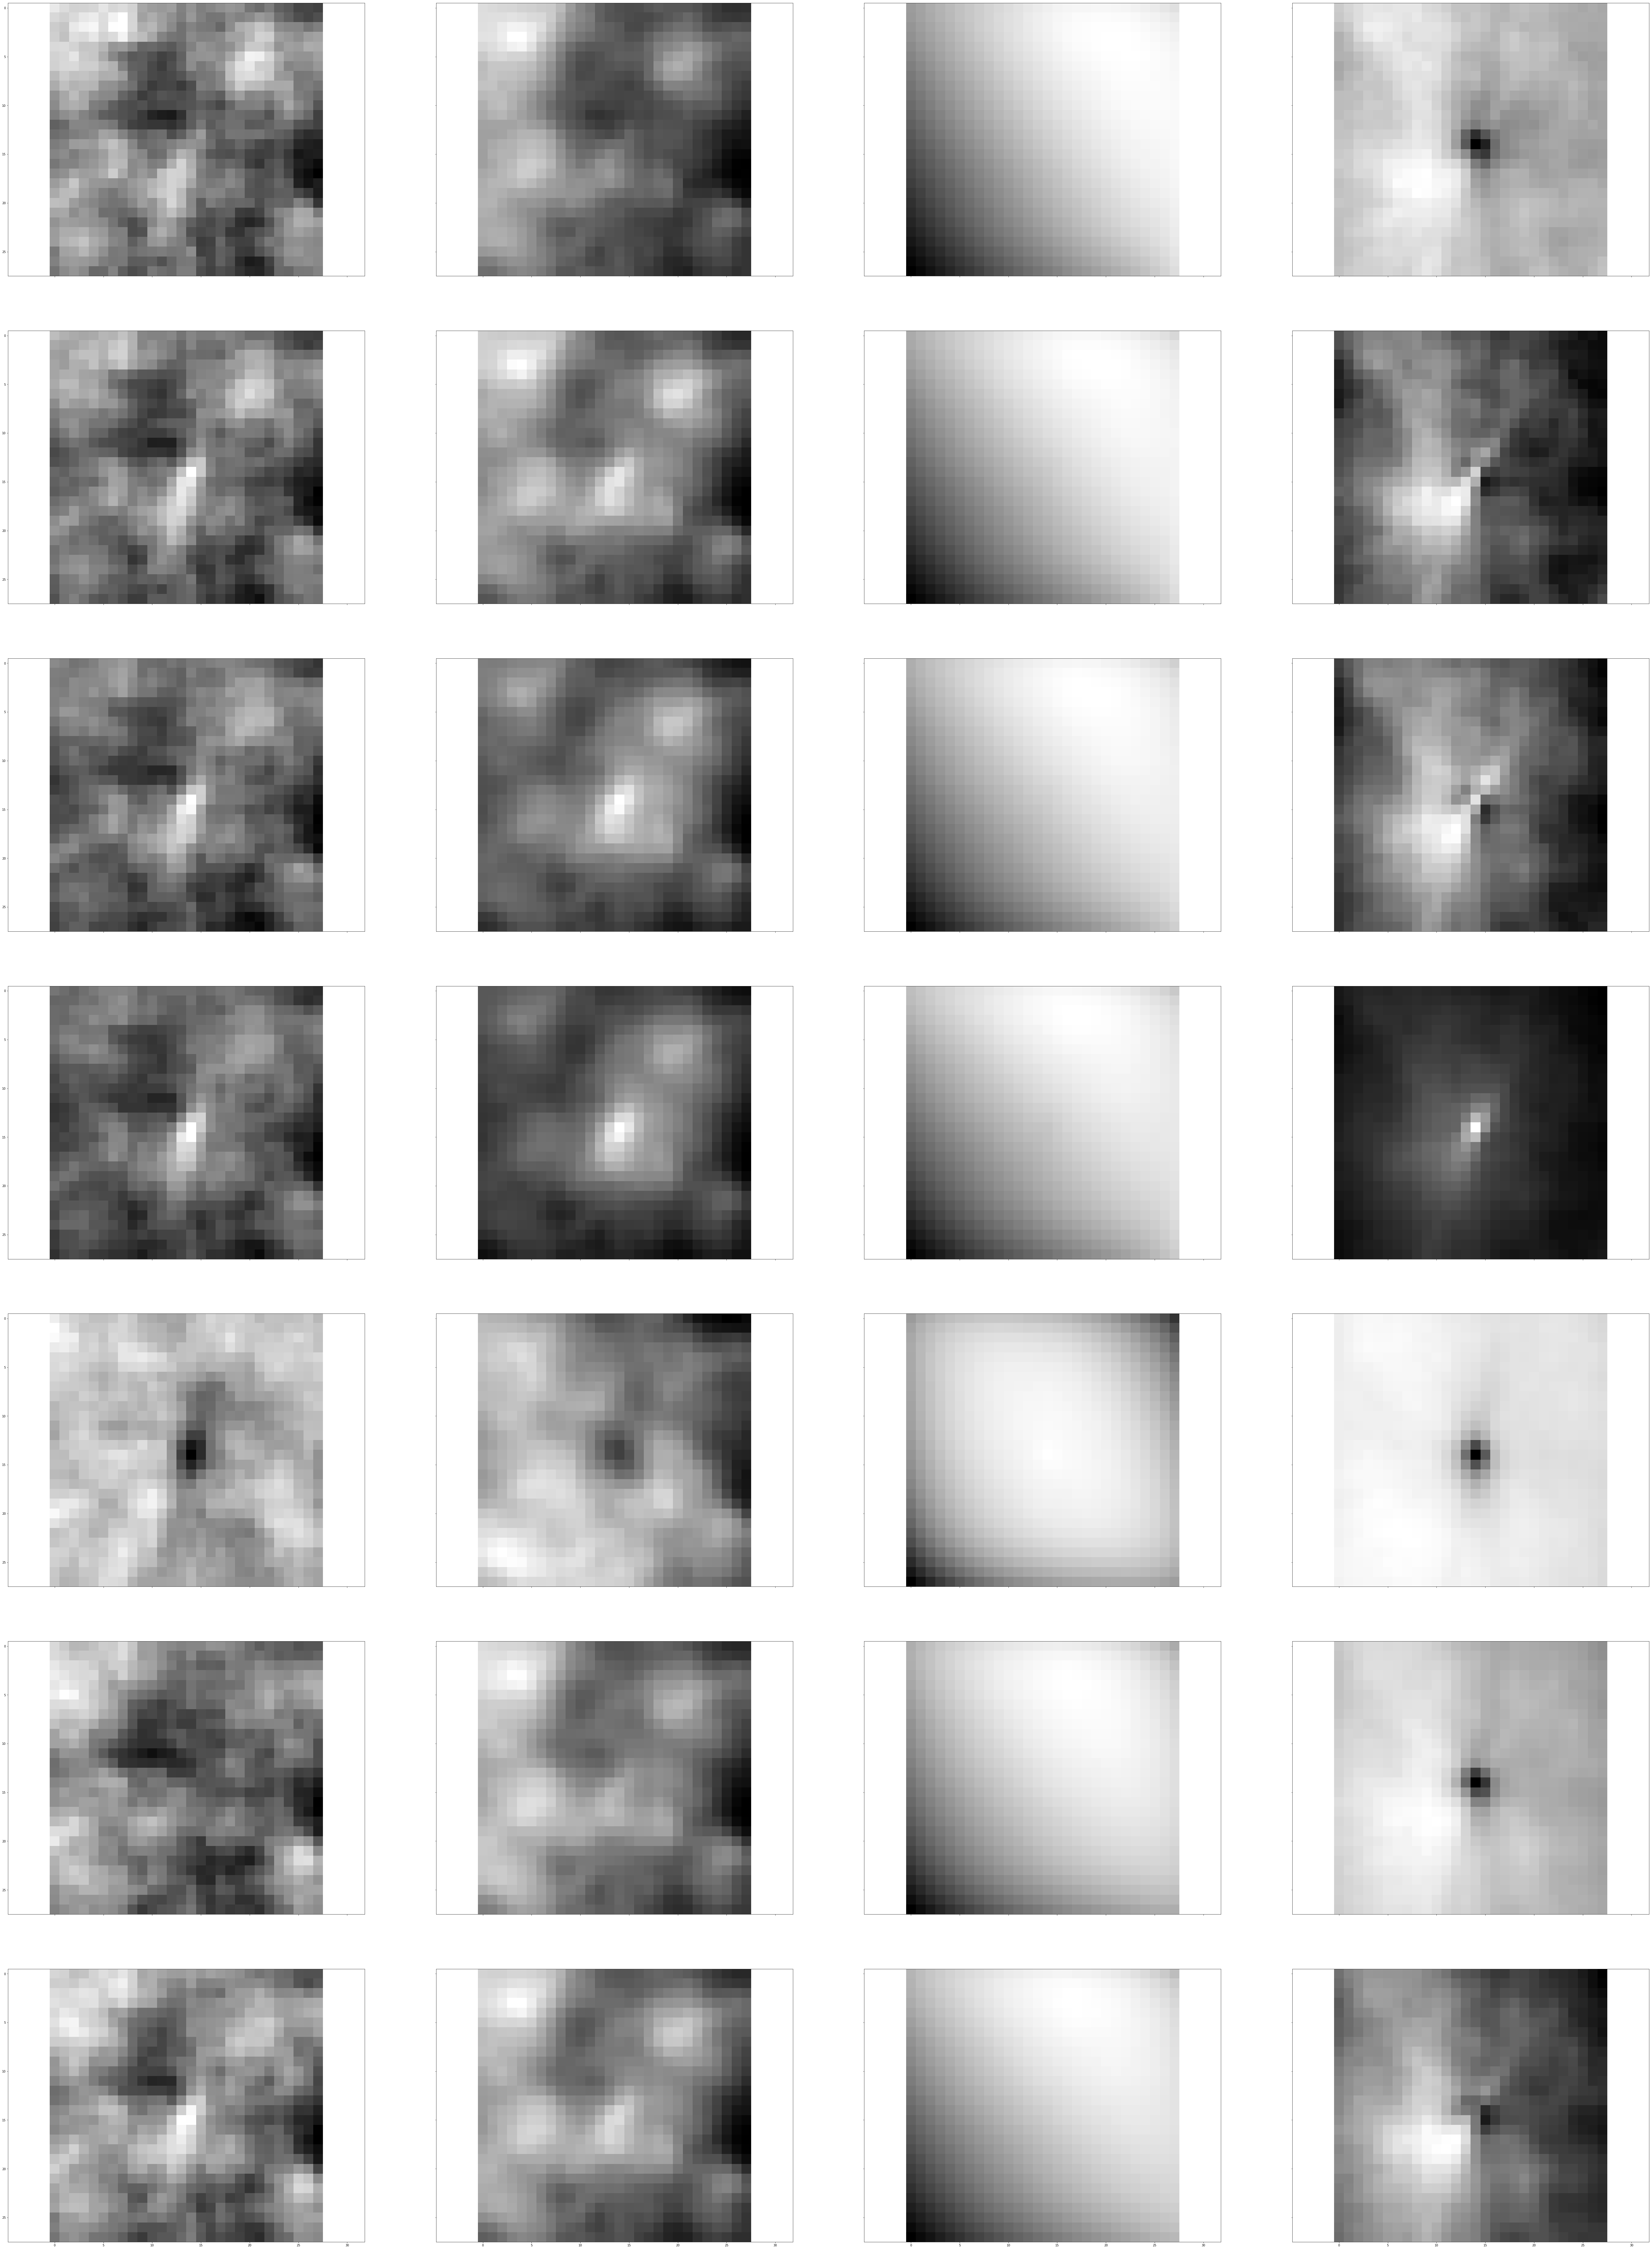

In [49]:
# band img - average over TP/FP/TN/FN (train set)
band_num = 7
plt.close('all')

fig, subfig = plt.subplots(nrows=band_num, ncols=4, sharex=True, sharey=True, figsize=(100,20*band_num))    
for img_col, idx_label in zip(range(4), ['TP', 'FP', 'TN', 'FN']):
    img_idx = train_index[train_metric.get_index(idx_label)]  
    if idx_label == 'TN':
        band_img = 0.0
        for idx in img_idx:
            band_img += get_patches(raw_image,road_mask,[topleft_coordinate[idx]],step=28)[0]
        band_img = band_img.mean(axis=0).reshape((7,28,28))
            
        for band_idx in range(band_num): 
            subfig[band_idx,img_col].imshow(band_img[band_idx], cmap=plt.get_cmap('gray'))

    else:
        band_img = get_patches(raw_image,road_mask,topleft_coordinate[img_idx], step=28)[0]
        band_img = band_img.mean(axis=0).reshape((7,28,28))

        for band_idx in range(band_num): 
            subfig[band_idx,img_col].imshow(band_img[band_idx], cmap=plt.get_cmap('gray'))

plt.savefig(model_path + 'Analysis/Band - avg on TP_FP_TN_FN.png')
plt.show()

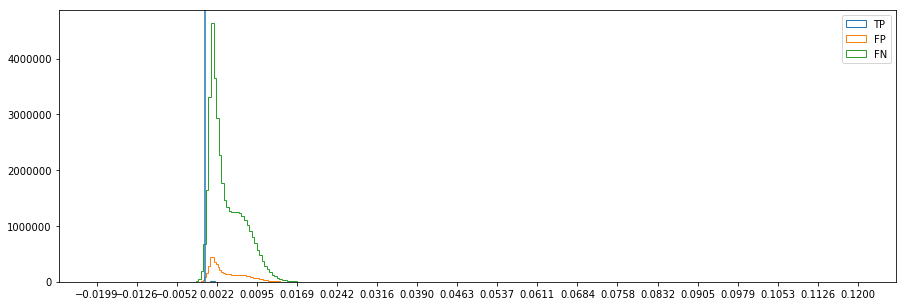

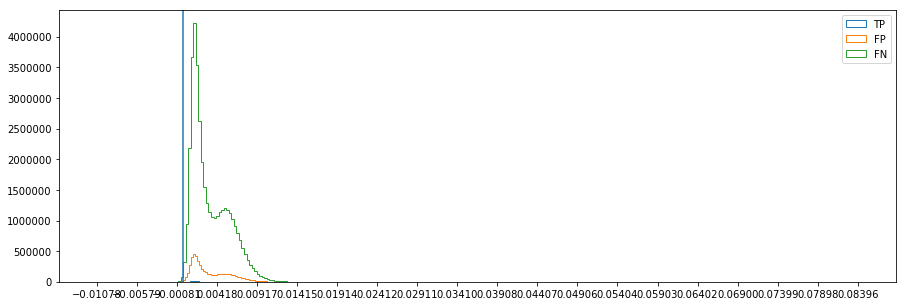

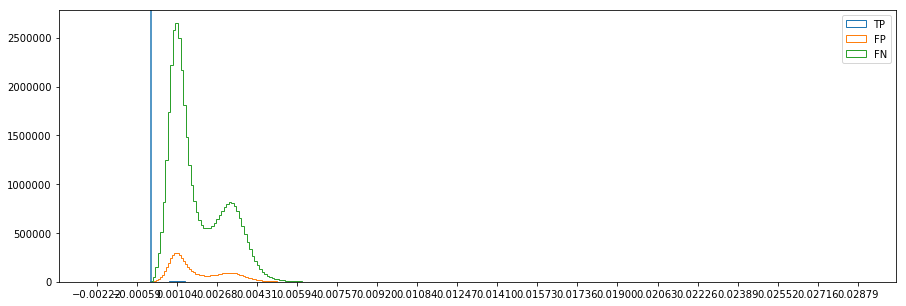

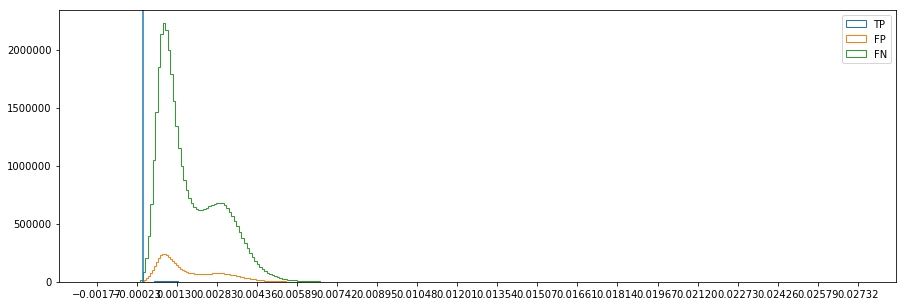

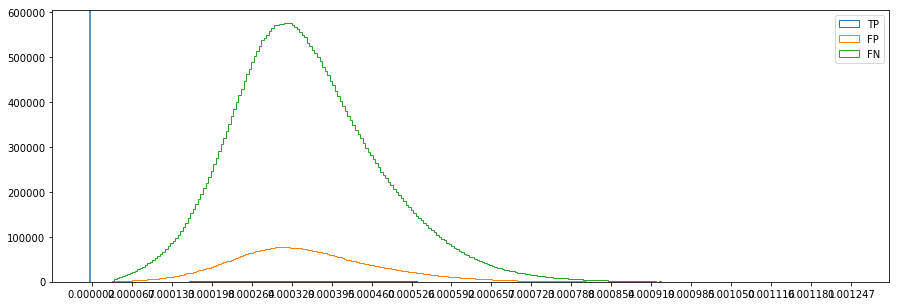

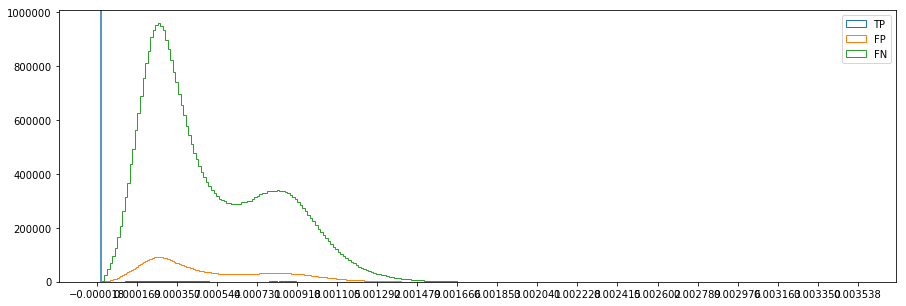

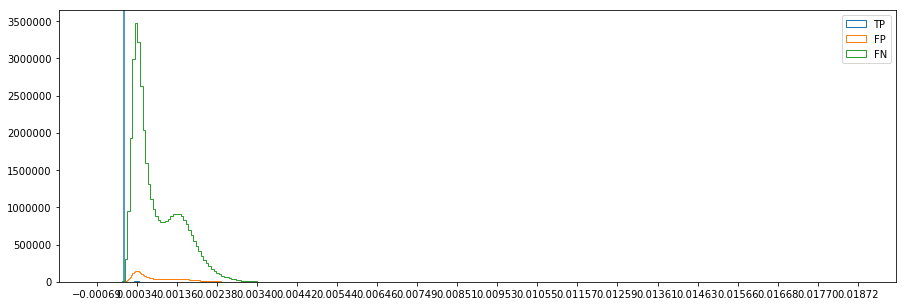

In [29]:
# band info - TP/FP/TN/FN on training set
band_num = 7
plt.close('all')
for band_idx in range(band_num):

    band_mu    = (mu.reshape((7,28,28)))[band_idx, :, :].flatten()
    band_sigma = (sigma.reshape((7,28,28)))[band_idx, :, :].flatten()
    
    plt.figure(figsize=(15,5))
    plt.axvline(0)
    
    for idx_name in ['TP', 'FP', 'FN']:
        
        band_norm = []
        for idx in train_metric.get_index(idx_name):
            band_norm.extend(
                (get_patches(raw_image, road_mask, [topleft_coordinate[idx]],
                             step=28, flatten=False)[0][0,band_idx].flatten()-band_mu)/band_sigma)
    
        band_norm = np.array(band_norm)
        plt.xticks(np.linspace(band_norm.min(),band_norm.max(), 20))
        plt.hist(band_norm, bins=300, histtype='step', label=idx_name)

    plt.legend()
    plt.savefig(model_path + 'Analysis/Band - info TP_FP_TN_FN/band ' + str(band_idx))
    plt.show()

    print("===================================================================================")

In [ ]:
# false pos
for i in range(10):
    idx = np.random.randint(0, len(false_pos_idx))
    idx = false_pos_idx[idx]
    print(idx)
    
    img  = X[idx].reshape(7, 28, 28)
    road = Road_patch[idx]
    show_image_against_road(img, road, size = -1, figsize=None, show_raw=False)
    for band in range(7):
        plt.imshow(img[band, :, :], cmap=plt.get_cmap('gray'))
        plt.show()
    break

In [ ]:
# true pos
for i in range(10):
    idx = np.random.randint(0, len(true_pos_idx))
    idx = true_pos_idx[idx]
    print(idx)
    
    img  = X[idx].reshape(7, 28, 28)
    road = Road_patch[idx]
    show_image_against_road(img, road, size = -1, figsize=None,show_raw=True)
    for band in range(7):
        plt.imshow(img[band, :, :], cmap=plt.get_cmap('gray'))
        plt.show()
    break

In [ ]:
# band info - whole dataset
band_num = 7
for band_idx, band_color in zip(range(band_num), reversed(cm.rainbow(np.linspace(0, 1, band_num)))):
    band       = X[:,band_idx,:,:]
    band_mu    = (mu.reshape((7,28,28)))[band_idx, :, :].flatten()
    band_sigma = (sigma.reshape((7,28,28)))[band_idx, :, :].flatten()

    band_norm = (band.reshape((band.shape[0], -1))-band_mu)/band_sigma
    print(band.shape, band_mu.shape, band_norm.shape)
    
    plt.figure(figsize=(20,7))
    plt.xticks(np.linspace(band_norm.min(),band_norm.max(), 20))
    plt.hist(band_norm.flatten(), bins=300, color=band_color, histtype='step')
    plt.axvline(0)
    plt.show()